<a href="https://colab.research.google.com/github/ShishirGTM32/Pytorch-Practice/blob/main/Image_Classification_using_Convolutional_Neural_Networks_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135M/135M [00:21<00:00, 6.17MB/s]


In [ ]:
# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['frog', 'bird', 'cat', 'deer', 'automobile', 'airplane', 'horse', 'dog', 'truck', 'ship']


In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [ ]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0677.png', '0548.png', '2061.png', '4964.png', '1047.png']


In [ ]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print("No. of test examples for ship:", len(ship_test_files))
print(ship_test_files[:5])

No. of test examples for ship: 1000
['0677.png', '0548.png', '0218.png', '0111.png', '0476.png']


In [ ]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [ ]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 32, 32]) 0


In [ ]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def show_img(img, label):
  print('Label: ', dataset.classes[label])
  plt.imshow(img.permute(1,2,0))

Label:  airplane


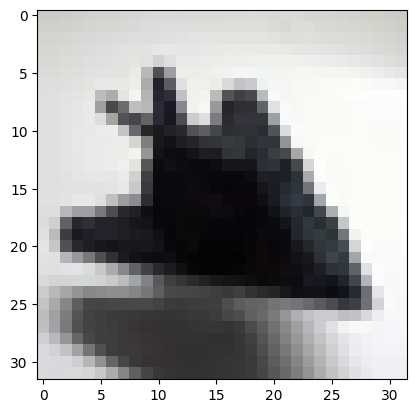

In [ ]:
img, label = dataset[0]
show_img(img, label)

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [ ]:
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = simple_model(images)
  print('out.shape: ', out.shape)
  break

images.shape:  torch.Size([128, 3, 32, 32])
out.shape:  torch.Size([128, 8, 16, 16])


In [56]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [57]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [58]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [59]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [60]:
device = get_default_device()
device

device(type='cuda')

In [61]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [62]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [63]:
model = to_device(Cifar10CnnModel(), device)

In [64]:
evaluate(model, val_dl)

{'val_loss': 2.302884817123413, 'val_acc': 0.10039062798023224}

In [65]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [66]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7190, val_loss: 1.3447, val_acc: 0.5071
Epoch [1], train_loss: 1.1906, val_loss: 1.0526, val_acc: 0.6253
Epoch [2], train_loss: 0.9092, val_loss: 0.9009, val_acc: 0.6867
Epoch [3], train_loss: 0.7323, val_loss: 0.7766, val_acc: 0.7292
Epoch [4], train_loss: 0.5952, val_loss: 0.6995, val_acc: 0.7613
Epoch [5], train_loss: 0.4759, val_loss: 0.7235, val_acc: 0.7626
Epoch [6], train_loss: 0.3756, val_loss: 0.7281, val_acc: 0.7669
Epoch [7], train_loss: 0.2868, val_loss: 0.7693, val_acc: 0.7669
Epoch [8], train_loss: 0.2083, val_loss: 0.8371, val_acc: 0.7744
Epoch [9], train_loss: 0.1664, val_loss: 0.9530, val_acc: 0.7714


In [67]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

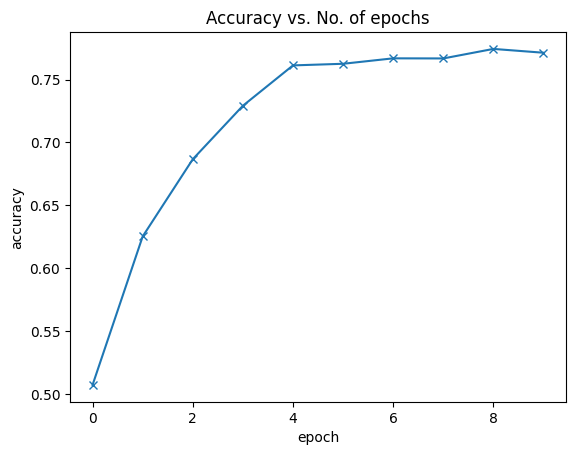

In [68]:
plot_accuracies(history)

In [69]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

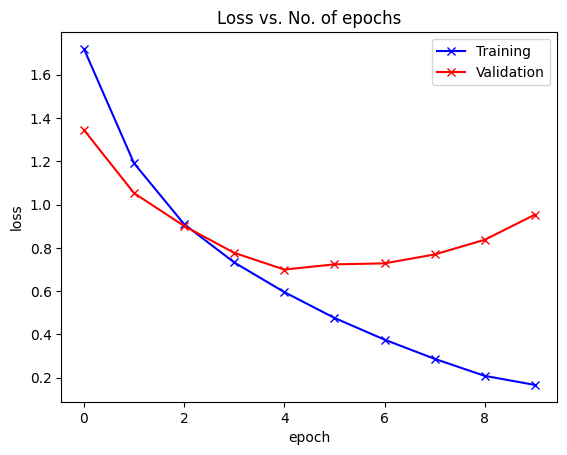

In [70]:
plot_losses(history)

In [71]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [73]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


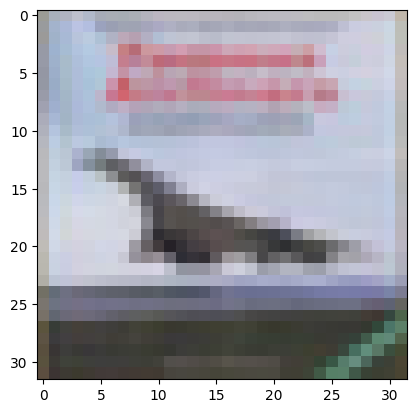

In [74]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


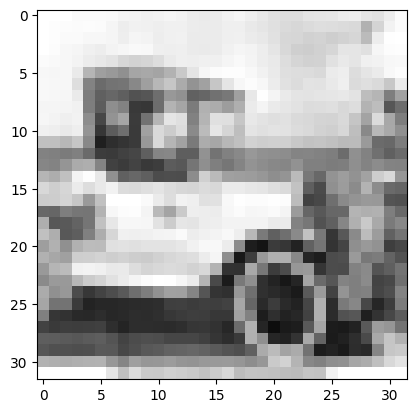

In [75]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


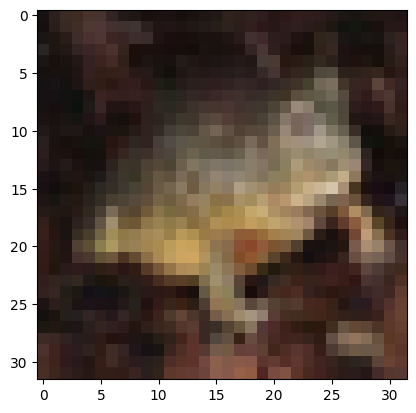

In [76]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))